# 建立自己的深度神经网络

**变量解析**:
-  $[l]$ 表示 $l^{th}$ 层. 
    - 例如: $a^{[L]}$ 是 $L^{th}$ 层激活函数. $W^{[L]}$ 和 $b^{[L]}$ 是 $L^{th}$ 层参数.
-  $(i)$ 表示 $i^{th}$ 样本. 
    - 例如: $x^{(i)}$ 是 $i^{th}$ 训练样本.
- 下划线 $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations).


## 1 -导入所需包


In [4]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from testCases_v3 import *
from dnn_utils_v2 import sigmoid, sigmoid_backward, relu, relu_backward

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - 任务提纲

- 初始化参数（两层神经网络和L层神经网络）
- 实现前向传播
     - 实现一层前向传播的线性部分 (结果是 $Z^{[l]}$).
     - 激励函数已给出 (relu/sigmoid).
     - 结合前面两步形成新的 [LINEAR->ACTIVATION] 前向传播.
     - 从1到L层，叠加 [LINEAR->RELU] 函数 L-1 次 并且在L层加上 [LINEAR->SIGMOID] 函数.形成了一个新的L层前向传播函数.
- 实现代价函数.
- 实现反向传播 .
    - 实现一层反向传播的线性部分.
    - 激励函数已给出 (relu_backward/sigmoid_backward) 
    - 结合前面两步形成新的 [LINEAR->ACTIVATION] 反向传播.
    - 叠加[LINEAR->RELU] L-1次 并且L层加上 [LINEAR->SIGMOID]函数. 形成了一个新的L层反向反向函数.
- 最终更新参数.

<img src="images/final outline.png" style="width:800px;height:500px;">
<caption><center> **Figure 1**</center></caption><br>


**注意** 每一次前向传播函数，都与反向传播函数有联系，在每次前向传播函数中存放在 cache 里面的变量在反向传播函数中用来计算梯度.

## 3 - 初始化

1）初始化两层函数

2）初始化L层函数
### 3.1 - 两层函数


**说明**:
- 模型结构为: *LINEAR -> RELU -> LINEAR -> SIGMOID*. 
- 权重初始化： np.random.randn(shape)*0.01.
- 偏置初始化： np.zeros(shape).

In [5]:
def initialize_parameters(n_x, n_h, n_y):
    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros((n_y,1))
    
    params = {"W1":W1,
              "b1":b1,
              "W2":W2,
              "b2":b2}
    return params

In [6]:
parameters = initialize_parameters(3,2,1)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01624345 -0.00611756 -0.00528172]
 [-0.01072969  0.00865408 -0.02301539]]
b1 = [[0.]
 [0.]]
W2 = [[ 0.01744812 -0.00761207]]
b2 = [[0.]]


### 3.2 -L层神经网络

当我们用python计算 $W X + b$ , 他将实现广播，例如: 

$$ W = \begin{bmatrix}
    j  & k  & l\\
    m  & n & o \\
    p  & q & r 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    a  & b  & c\\
    d  & e & f \\
    g  & h & i 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    s  \\
    t  \\
    u
\end{bmatrix}\tag{2}$$

 $WX + b$ :

$$ WX + b = \begin{bmatrix}
    (ja + kd + lg) + s  & (jb + ke + lh) + s  & (jc + kf + li)+ s\\
    (ma + nd + og) + t & (mb + ne + oh) + t & (mc + nf + oi) + t\\
    (pa + qd + rg) + u & (pb + qe + rh) + u & (pc + qf + ri)+ u
\end{bmatrix}\tag{3}  $$


**说明**:
- 模型结构为： *[LINEAR -> RELU] $ \times$ (L-1) -> LINEAR -> SIGMOID*. I.e.
- 前面 $L-1$ 隐藏层激活函数用relu，输出层用sigmoid函数.
- 权重初始化：np.random.rand(shape) * 0.01.
- 偏置初始化：np.zeros(shape).
- 我们将存储 $n^{[l]}$, 在不同层的单元数, 即：layer_dims. 
- 例如： `layer_dims` ：[2,4,1]: 表示两个输入，一个隐藏，一个输出.
- 即`W1` ：(4,2),  `b1` ：(4,1),  `W2` ：(1,4) , `b2` : (1,1). 
- 下面是一层时,W、b的初始化：
```python
    if L == 1:
        parameters["W" + str(L)] = np.random.randn(layer_dims[1], layer_dims[0]) * 0.01
        parameters["b" + str(L)] = np.zeros((layer_dims[1], 1))
```

In [40]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    
    params = {}
    L = len(layer_dims)
    
    #str(i) 表示W1,W2后面接着的数字1，2
    for i in range(1,L):
        params["W" + str(i)] = np.random.randn(layer_dims[i],layer_dims[i-1]) * 0.01
        params["b" + str(i)] = np.zeros((layer_dims[i],1))
    
    return params

In [41]:
parameters = initialize_parameters_deep([5,4,3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01788628  0.0043651   0.00096497 -0.01863493 -0.00277388]
 [-0.00354759 -0.00082741 -0.00627001 -0.00043818 -0.00477218]
 [-0.01313865  0.00884622  0.00881318  0.01709573  0.00050034]
 [-0.00404677 -0.0054536  -0.01546477  0.00982367 -0.01101068]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01185047 -0.0020565   0.01486148  0.00236716]
 [-0.01023785 -0.00712993  0.00625245 -0.00160513]
 [-0.00768836 -0.00230031  0.00745056  0.01976111]]
b2 = [[0.]
 [0.]
 [0.]]


## 4 - 前向传播

### 4.1 - 线性前向

你将实现下面三个函数：

- LINEAR
- LINEAR -> ACTIVATION where ACTIVATION will be either ReLU or Sigmoid. 
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (whole model)

线性前向用下列等式计算:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$  
（$A^{[0]} = X$）


**提醒**:
上述公式你可以用 np.dot()来表示.

In [61]:
#实现一层前向传播
def linear_forward(A, W, b):

    Z = np.dot(W,A) + b
    
    #assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [62]:
A, W, b = linear_forward_test_case()
#这次的输出，下一次的输入
#cache 里面包含的是A、 W、 b每一个变量的值
Z, linear_cache = linear_forward(A, W, b)
print("Z = " + str(Z))
print(linear_cache)

Z = [[ 3.26295337 -1.23429987]]
(array([[ 1.62434536, -0.61175641],
       [-0.52817175, -1.07296862],
       [ 0.86540763, -2.3015387 ]]), array([[ 1.74481176, -0.7612069 ,  0.3190391 ]]), array([[-0.24937038]]))


### 4.2 -线性前向激活函数


- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$ ，表述如下： 
``` python
A, activation_cache = sigmoid(Z)
```

- **ReLU**:  $A = RELU(Z) = max(0, Z)$ ，表述如下： 
``` python
A, activation_cache = relu(Z)
```

**提醒**: 实现线性前向函数 *LINEAR->ACTIVATION* 层. 即: 

$A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$

激活函数 "g" 可以是 sigmoid() 或者 relu().

In [63]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == 'sigmoid':
        Z,linear_cache = linear_forward(A_prev, W, b)
        A,activation_cache = sigmoid(Z)
        
    elif activation == 'relu':
        Z,linear_cache = linear_forward(A_prev, W, b)
        A,activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)
    
    return A,cache

In [64]:
A_prev, W, b = linear_activation_forward_test_case()

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "sigmoid")
print("With sigmoid: A = " + str(A))

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "relu")
print("With ReLU: A = " + str(A))

With sigmoid: A = [[0.96890023 0.11013289]]
With ReLU: A = [[3.43896131 0.        ]]


**注意**: 在深度学习中， "[LINEAR->ACTIVATION]" 在神经网络里面被看作一层，而不是两层

### d)L层模型

<img src="images/model_architecture_kiank.png" style="width:600px;height:300px;">
<caption><center> **Figure 2** : *[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model</center></caption><br>


**Instruction**:  $A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. (有时叫做 `Yhat`, i.e.,即$\hat{Y}$.) 

**技巧**:
- 用之前你已经写过的函数 
- 用一个for循环来迭代L-1次 [LINEAR->RELU] 
- 别忘了跟踪“缓存”列表中的缓存. 可以用 `list.append(cache)`.

In [96]:
#  当 A0 = X 这样赋值时，会出现 ValueError: shapes (3,4) and (5,4) not aligned: 4 (dim 1) != 5 (dim 0),
#  A_prev = A 是每次迭代都需要更新的值

#params["W" + str(i)]：for循环每次的i体现在W后面接着的数字变化，即i为变换的层数
#list.append(cache):list表示变量，即list是caches，而不是要caches = list.append(cache)
def L_model_forward(X, params):
   
    caches = []
    A = X
    L = len(params) // 2 #在神经网络中的层数
    
    for i in range(1, L):
        
        A_prev = A
        A, cache = linear_activation_forward(A_prev, params["W" + str(i)], params["b" + str(i)], activation = "relu")
        caches.append(cache)
        
    AL,cache = linear_activation_forward(A, params["W" + str(L)], params["b" + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    return AL,caches

In [97]:
X, parameters = L_model_forward_test_case_2hidden()
AL, caches = L_model_forward(X, parameters)
print("AL = " + str(AL))
print("Length of caches list = " + str(len(caches)))

AL = [[0.03921668 0.70498921 0.19734387 0.04728177]]
Length of caches list = 3


## 5 - 计算代价函数

**说明**: 

1）计算交叉熵成本 $J$

2）用下列式子: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$


In [106]:
#每一次函数定义的参数要知道含义：AL:预测的Yhat, Y:实际值
def compute_cost(AL, Y):
    m = Y.shape[1]
    
    #第一种
    J = -np.sum((Y * np.log(AL)) + (1 - Y) * np.log(1 - AL)) /m
    #第二种：将 * 用np.multiply代替，其余不变
#     logprosp = np.multiply(Y, np.log(AL))
#     logprosp_1 = np.multiply((1 - Y), np.log(1 - AL))
#     J = -np.sum(logprosp+logprosp_1) / m
    
    cost = np.squeeze(J)
    
    return cost

In [107]:
Y, AL = compute_cost_test_case()

print("cost = " + str(compute_cost(AL, Y)))

cost = 0.414931599615397


## 6 - 反向传播模型

**提醒**: 
<img src="images/backprop_kiank.png" style="width:650px;height:250px;">
<caption><center> **Figure 3** : 前向和反向传播模型: *LINEAR->RELU->LINEAR->SIGMOID* <br> *紫色代表前向传播，红色代表反向传播.*  </center></caption>

<!-- 
For those of you who are expert in calculus (you don't need to be to do this assignment), the chain rule of calculus can be used to derive the derivative of the loss $\mathcal{L}$ with respect to $z^{[1]}$ in a 2-layer network as follows:

$$\frac{d \mathcal{L}(a^{[2]},y)}{{dz^{[1]}}} = \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}} \tag{8} $$

In order to calculate the gradient $dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$, you use the previous chain rule and you do $dW^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial W^{[1]}}$. During the backpropagation, at each step you multiply your current gradient by the gradient corresponding to the specific layer to get the gradient you wanted.

Equivalently, in order to calculate the gradient $db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$, you use the previous chain rule and you do $db^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$.

This is why we talk about **backpropagation**.
!-->

反向传播三步走:
- LINEAR backward
- LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID backward (whole model)

### 6.1 - 线性反向

对于 $l$ 层, 线性部分为: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ .

已知： $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$.

最终： $(dW^{[l]}, db^{[l]} dA^{[l-1]})$.

<img src="images/linearback_kiank.png" style="width:250px;height:300px;">
<caption><center> **Figure 4** </center></caption>

三个输出 $(dW^{[l]}, db^{[l]}, dA^{[l]})$ 是为了 $dZ^{[l]}$的输入.

如下三个公式:
$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


In [111]:
def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ) / m
    dA_prev = np.dot(W.T,dZ)
    
#     grads = {"dW":dW,
#              "db":db,
#              "dA_prev":dA_prev}
    
    return dA_prev, dW, db

In [113]:
# Set up some test inputs
dZ, linear_cache = linear_backward_test_case()

dA_prev, dW, db = linear_backward(dZ, linear_cache)
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

dA_prev = [[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]]
dW = [[-0.10076895  1.40685096  1.64992505]]
db = 0.5062944750065832


### 6.2 - 线性反向激励函数

为帮助实现`linear_activation_backward`函数, 提供两个反向函数:
- **`sigmoid_backward`**:

```python
dZ = sigmoid_backward(dA, activation_cache)
```

- **`relu_backward`**: 

```python
dZ = relu_backward(dA, activation_cache)
```

如果 $g(.)$ 是激励函数, 
`sigmoid_backward`和 `relu_backward` 来计算 $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}) \tag{11}$$.  


In [114]:
def linear_activation_backward(dA, cache, activation):
    
    linear_cache,activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        
    return dA_prev, dW, db
    

In [115]:
AL, linear_activation_cache = linear_activation_backward_test_case()

dA_prev, dW, db = linear_activation_backward(AL, linear_activation_cache, activation = "sigmoid")
print ("sigmoid:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")

dA_prev, dW, db = linear_activation_backward(AL, linear_activation_cache, activation = "relu")
print ("relu:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

sigmoid:
dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = -0.057296222176291135

relu:
dA_prev = [[ 0.44090989  0.        ]
 [ 0.37883606  0.        ]
 [-0.2298228   0.        ]]
dW = [[ 0.44513824  0.37371418 -0.10478989]]
db = -0.2083789237027353


### 6.3 - L层反向模型
cache --> [X,W,b,Z]
在L_model_forward模型里面你将会用cache里面的变量计算梯度，且从第L层开始迭代所有的隐藏层

<img src="images/mn_backward.png" style="width:450px;height:300px;">
<caption><center>  **Figure 5** : Backward pass  </center></caption>

** 初始化反向传播**:
输出： 
$A^{[L]} = \sigma(Z^{[L]})$. Your code thus needs to compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.

```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) 
```
grads --> [dA、dW、db]

dAL   --> LINEAR->SIGMOID backward

for循环 --> LINEAR->RELU backward 

$$grads["dW" + str(l)] = dW^{[l]}\tag{15} $$

对于l = 3 : $dW^{[l]}$ --> `grads["dW3"]`.

**实现反向传播模型**： *[LINEAR->RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* .

In [172]:
def L_model_backward(AL, Y, caches):
    
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    #grads["dA" + str(L-1)] = dAL-1、grads["dW" + str(L)] = dWL、grads["db" + str(L)] = dbL
    #即下列式子为 dAL-1（dA_prev) ,dWL, dbL = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    #充分运用之前的函数,误区：grads["dA" + str(L-1)],grads["dW" + str(L)],grads["db" + str(L)] = dAL-1,dWL,dbL
    #L = 1,2,.....L
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y,1 - AL))
    current_cache = caches[L-1]
    grads["dA" + str(L-1)],grads["dW" + str(L)],grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    #grads["dA" + str(i+1)] : i=0相当于从dA1算起，则str(i +1)
    #for i in range(1,L-1):
    for i in reversed(range(L-1)):
        current_cache = caches[i]
        dA_prev, dW, db = linear_activation_backward(grads["dA" + str(i+1)], current_cache, activation = "relu")
        grads["dA" + str(i)] = dA_prev
        grads["dW" + str(i + 1)] = dW
        grads["db" + str(i + 1)] = db
        
    return grads

In [173]:
AL, Y_assess, caches = L_model_backward_test_case()
grads = L_model_backward(AL, Y_assess, caches)
print_grads(grads)

0
dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
db1 = -0.24842412164385988
dA1 = [[ 0.12913162 -0.44014127]
 [-0.14175655  0.48317296]
 [ 0.01663708 -0.05670698]]


### 6.4 - 更新参数
 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

$\alpha$ 是学习率. 更新完参数后，放在params里面. 

In [186]:
def update_parameters(params, grads, learning_rate):
    
    L = len(params) // 2 #神经网络层数
    
    for i in range(L):
        params["W" + str(i + 1)] = params["W" + str(i + 1)] - learning_rate * grads["dW" + str(i + 1)]
        params["b" + str(i + 1)] = params["b" + str(i + 1)] - learning_rate * grads["db" + str(i + 1)]
    
    return params

In [187]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads, 0.1)

print ("W1 = "+ str(parameters["W1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["W2"]))
print ("b2 = "+ str(parameters["b2"]))

W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]



## 7 - 总结

#Steps:

1、 Parameters initialization

2、 Loop (gradient descent)

3、 Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.

4、 Compute cost.

5、 Backward propagation.

6、 Update parameters.

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912678
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605748


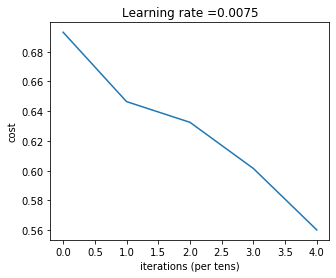

Accuracy: 0.6555023923444976
Accuracy: 0.3400000000000001
Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047


In [ ]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v2 import *
import imageio
import scipy.misc

#two_layer_model
 
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
 
    np.random.seed(1)
    grads = {}
    costs = []                              
    m = X.shape[1]                          
    (n_x, n_h, n_y) = layers_dims
 
    parameters = initialize_parameters(n_x, n_h, n_y)

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
 
 
    for i in range(0, num_iterations):

        A1, cache1 = linear_activation_forward(X, W1, b1, activation="relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation="sigmoid")

        cost = compute_cost(A2, Y)

        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
 
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation="sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation="relu")

        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
 
        parameters = update_parameters(parameters, grads, learning_rate)

 
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
 

        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
 
    # plot the cost
 
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
 
    return parameters



# L_layer_model
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):  # lr was 0.009


    np.random.seed(1)
    costs = []  # keep track of cost

    parameters = initialize_parameters_deep(layers_dims)
   
    for i in range(0, num_iterations):
        
        AL, caches = L_model_forward(X, parameters)

        cost = compute_cost(AL, Y)

        grads = L_model_backward(AL, Y, caches)

        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters


if __name__ == '__main__':
    aa = time.time()
    np.random.seed(1)
    train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
    # Reshape the training and test examples
    train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0],
                                           -1).T  # The "-1" makes reshape flatten the remaining dimensions
    test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T
    
    num_px = train_x_orig.shape[1]
    
    # Standardize data to have feature values between 0 and 1.
    train_x = train_x_flatten / 255.
    test_x = test_x_flatten / 255.

    n_x = 12288  # num_px * num_px * 3
    n_h = 7
    n_y = 1
    layers_dims = (n_x, n_h, n_y)
    parameters = two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), num_iterations=500, print_cost=True)
    predictions_train = predict(train_x, train_y, parameters)
    predictions_test = predict(test_x, test_y, parameters)

    layers_dims_L = [12288, 20, 7, 5, 1]  # 5-layer model
    parameters = L_layer_model(train_x, train_y, layers_dims_L, num_iterations=500, print_cost=True)
    
    my_image = "img.png"  
    my_label_y = [0]  

    from skimage.transform import resize
    fname = "image/" + my_image
    image = np.array(imageio.imread(fname))
    my_image = resize(image, output_shape=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
    #my_image = resize(image, size=(64, 64)).reshape((64 * 64 * 3, 1))
    my_predicted_image = predict(my_image, my_label_y, parameters)

    plt.imshow(image)
    print("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[
        int(np.squeeze(my_predicted_image)),].decode("utf-8") + "\" picture.")

    